In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics
os.chdir("..")
os.getcwd()

from platform import python_version
print(python_version())

import importlib.util

#spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src\\data_prep.py")
spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src/data_prep.py")
prep_data = importlib.util.module_from_spec(spec_data_pred)
spec_data_pred.loader.exec_module(prep_data)

#spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src\\plotting_printing.py")
spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src/plotting_printing.py")
plotting_printing = importlib.util.module_from_spec(spec_plotting_printing)
spec_plotting_printing.loader.exec_module(plotting_printing)

3.8.10


### Purpose of this notebook: 

# PoC for a multidimensional power law approach for training dataset size prediction.

* Using Cifar10 data
* and a standard cnn architecture
* Varying the number of images per class with different number of overall training dataset sizes
* Collect accuracies for each experiment
* Fit a power law with a linear combination as input.

# statistical models considered:

* ### power law: 
    * Just using last epoch
    * Using all epochs
    * ref: Just using overall training dataset size with last epoch


# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [2]:
model_type = "powerlaw_all_epochs"

In [3]:
results_full_training = pd.read_csv("csv_files/Cifar10_acc_full_train_10_iterations_20230714.csv")
results_full_training.head(20)
mask = results_full_training.epoch == 195
results_full_training[mask]

,itterations,accs,epoch,train_loss,val_loss
39,0,83.46,195,1.157479,18.912277
79,1,83.48,195,1.174477,19.066725
119,2,83.51,195,1.198949,19.339757
159,3,83.79,195,1.553496,18.447202
199,4,82.88,195,1.164441,19.580478
239,5,84.25,195,1.303931,18.671946
279,6,84.12,195,1.299730,18.447593
319,7,83.22,195,1.029287,19.823285
359,8,83.67,195,1.349029,18.688389
399,9,83.08,195,1.087539,19.094872


In [4]:
results_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_20230705.csv")
results_val_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_val_20230708.csv")
results_4500_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jelena_batch_size_512_mixture_design_maximin_subsetsize_4500_20230715.csv")

#prep_data
data_dict = prep_data.prep_data_all_epochs(results_from_file, 
              results_val_from_file, 
              results_4500_from_file, 
              min_epoch = 20)

# the following unacks all dict items into a corresonding variable:
locals().update(data_dict)

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} &  accs &  plane &   car &  bird &    cat &    deer &    dog &    frog &  horse &   ship &  truck &  epochs\_trained &  total\_training\_size \\
\midrule
0 &  0.20 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              20 &              4999.00 \\
1 &  0.25 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              25 &              4999.00 \\
2 &  0.24 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              30 &              4999.00 \\
3 &  0.26 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              35 &              4999.00 \\
4 &  0.29 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              40 &              4999.00 \\
\

,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0
4,0,0.8035,95.364757,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,40,45500.0


(12, 10800)


,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0
4,0,0.8035,95.364757,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,40,45500.0


In [5]:
"potentially to be deleted "
props = dict(boxstyle='round', facecolor='white', alpha=0.5)


# powerlaw - full linear option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

In [6]:
results_pred_orig

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0


In [7]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained)**b) * c

np.random.seed(seed=4213523)
n_p = 14
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch
param_value,-0.028546,0.381403,0.455277,0.65913,0.525844,0.5171,0.282341,0.523603,0.47344,0.502159,0.64217,0.381459,0.424649,0.670846


\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch \\
\midrule
param\_value & -0.03 & 0.38 & 0.46 &   0.66 & 0.53 &  0.52 & 0.28 &  0.52 & 0.47 &  0.50 &   0.64 &  0.38 &   0.42 &   0.67 \\
\bottomrule
\end{tabular}

0.0020050154661036355


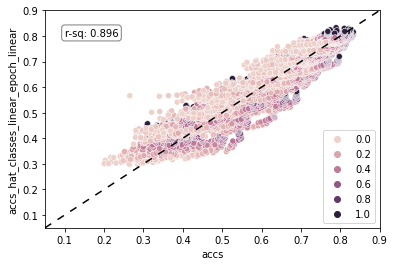

0.8958535485183345
mean val loss: 0.002150428324820422


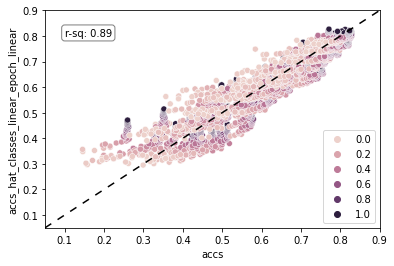

r_square val: 0.8896818174384044


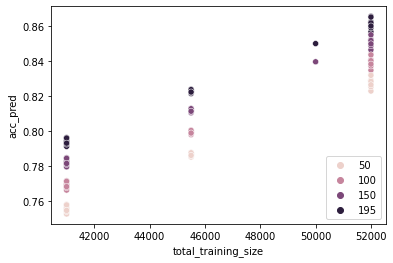

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.849974
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.839560
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.823757
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.812809
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.800368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.825312
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.860039
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.849818
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.838231


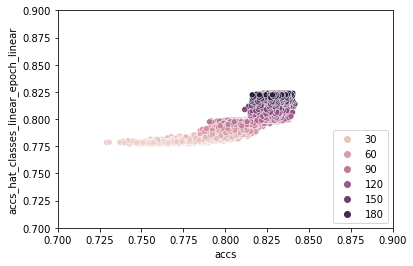

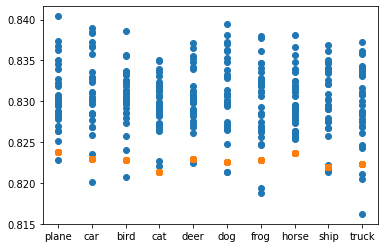

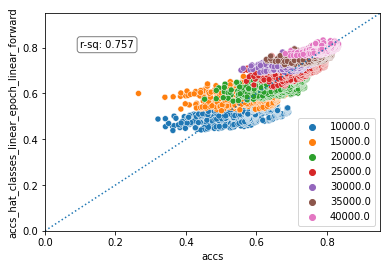

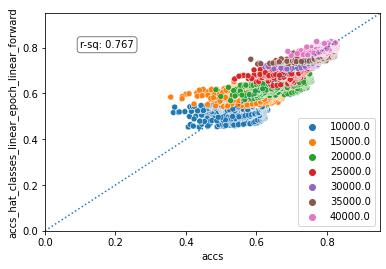

In [8]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch"]
if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False)
    results = plotting_printing.forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
    plotting_printing.plot_forward_testing(results, y_hat_name)
    results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
    plotting_printing.plot_forward_testing(results_val, y_hat_name)



### Using an arctan effect for epoch only, but linear for classes:

In [9]:
y_hat_name = "accs_hat_classes_linear_epoch_arctan"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**b) * c

np.random.seed(seed=42135230)
n_p = 15
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")


param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch_2
param_value,-0.279471,0.319458,0.530976,1.163862,0.94517,0.920903,0.513874,0.939791,0.842042,0.900487,1.147606,0.68831,0.760851,1.101161,7.240699


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch\_2 \\
\midrule
param\_value & -0.28 & 0.32 & 0.53 &   1.16 & 0.95 &  0.92 & 0.51 &  0.94 & 0.84 &  0.90 &   1.15 &  0.69 &   0.76 &   1.10 &     7.24 \\
\bottomrule
\end{tabular}

0.0017791582254863777


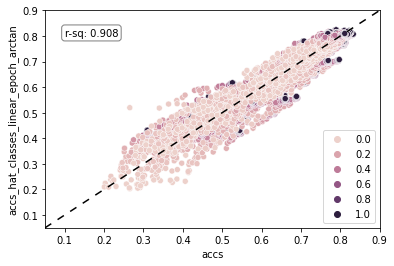

0.9075852436346017
mean val loss: 0.0019092462117026436


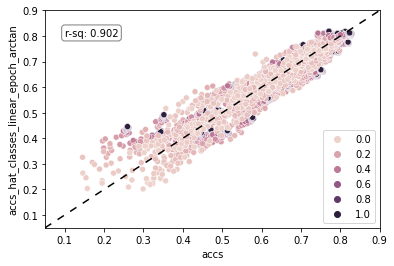

r_square val: 0.9020545954930927


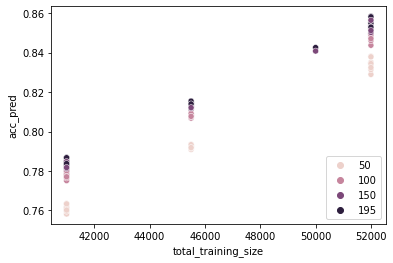

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.842601
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.840831
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.815480
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.813615
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.809200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.831454
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.852987
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.851251
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.847145


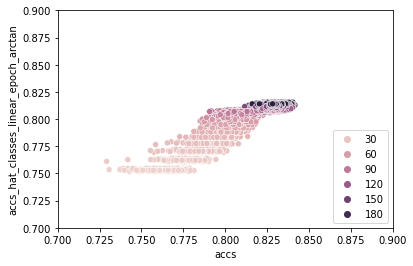

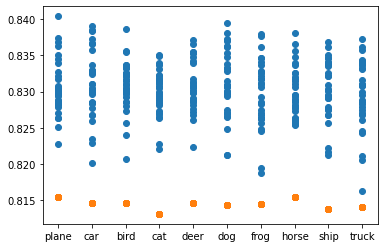

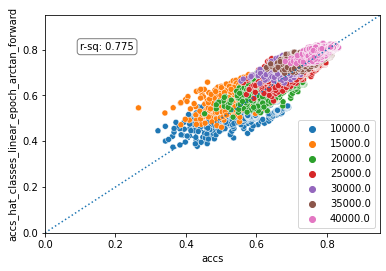

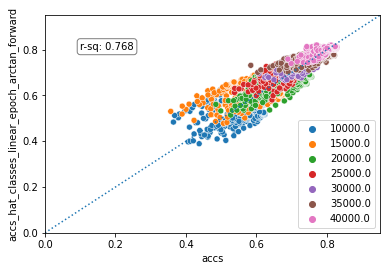

In [11]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch", "epoch_2"]


if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)
    results = plotting_printing.forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
    plotting_printing.plot_forward_testing(results, y_hat_name)
    results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
    plotting_printing.plot_forward_testing(results_val, y_hat_name)
    


### using an arctan effect for every class:

In [12]:
y_hat_name = "accs_hat_classes_arctan_epoch_artan"

def func(x, a: float, b: float, c: float, d0:float, d0_2:float, d1:float, d1_2:float, d2:float, d2_2:float, d3:float, d3_2:float, d4:float, d4_2:float, d5:float, d5_2:float, d6:float, d6_2:float, d7:float, d7_2:float, d8:float, d8_2:float, d9:float, d9_2:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**b) * c

np.random.seed(seed=42135230)
n_p = 25
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 50))
    converged = True
except:
    print("did not converge")



param_name,a,b,c,plane_1,plane_2,car_1,car_2,bird_1,bird_2,cat_1,cat_2,deer_1,deer_2,dog_1,dog_2,frog_1,frog_2,horse_1,horse_2,ship_1,ship_2,truck_1,truck_2,epoch_1,epoch_2
param_value,0.151506,1.383822,0.022243,0.738814,9.543439,0.83619,15.662931,0.664464,7.414611,0.449109,6.138021,0.702953,4.030186,0.566592,5.307911,0.738942,10.231198,0.840284,12.558622,0.798474,17.630757,0.719177,17.850345,1.066141,8.695602


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &    c &  plane\_1 &  plane\_2 &  car\_1 &  car\_2 &  bird\_1 &  bird\_2 &  cat\_1 &  cat\_2 &  deer\_1 &  deer\_2 &  dog\_1 &  dog\_2 &  frog\_1 &  frog\_2 &  horse\_1 &  horse\_2 &  ship\_1 &  ship\_2 &  truck\_1 &  truck\_2 &  epoch\_1 &  epoch\_2 \\
\midrule
param\_value & 0.15 & 1.38 & 0.02 &     0.74 &     9.54 &   0.84 &  15.66 &    0.66 &    7.41 &   0.45 &   6.14 &    0.70 &    4.03 &   0.57 &   5.31 &    0.74 &   10.23 &     0.84 &    12.56 &    0.80 &   17.63 &     0.72 &    17.85 &     1.07 &     8.70 \\
\bottomrule
\end{tabular}

0.000501351140777659


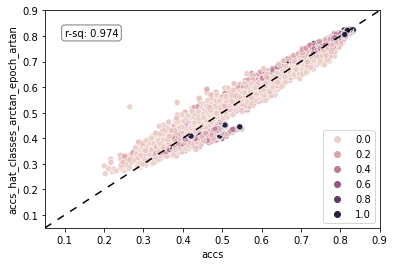

0.9739583344163694
mean val loss: 0.0005784605761183358


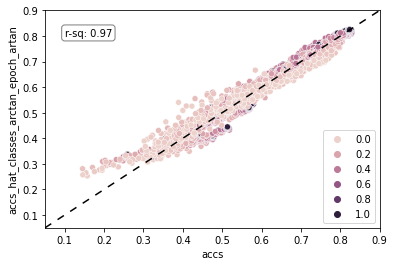

r_square val: 0.9703246470926961


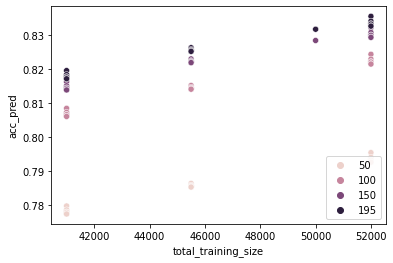

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.831678
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.828367
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.825485
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.822183
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.814357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.792653
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.832591
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.829279
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.821431


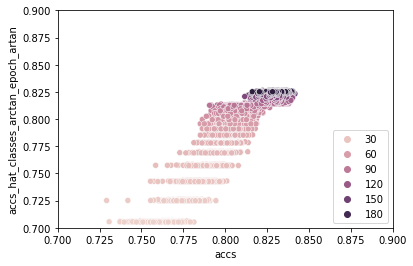

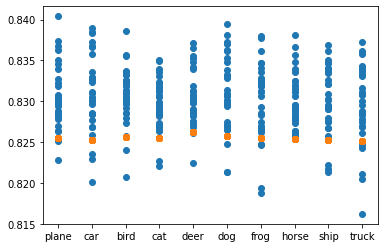

param_value           
param_no           1          2
feature                        
bird        0.664464   7.414611
car         0.836190  15.662931
cat         0.449109   6.138021
deer        0.702953   4.030186
dog         0.566592   5.307911
epoch       1.066141   8.695602
frog        0.738942  10.231198
horse       0.840284  12.558622
plane       0.738814   9.543439
ship        0.798474  17.630757
truck       0.719177  17.850345

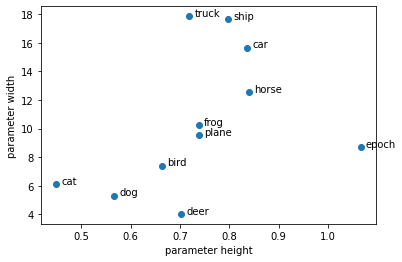

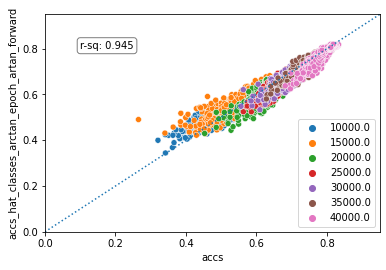

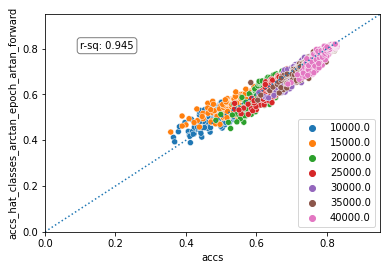

In [13]:
param_names = ["a", "b", "c"]
for c in classes:
    param_names = param_names + [f"{c}_1", f"{c}_2"]
param_names = param_names + ["epoch_1", "epoch_2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=True)
    results = plotting_printing.forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
    plotting_printing.plot_forward_testing(results, y_hat_name)
    results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
    plotting_printing.plot_forward_testing(results_val, y_hat_name)
    


# all class counts linear, but including quadratic term for epoch:

In [14]:
y_hat_name = "accs_hat_classes_linear_epoch_sq"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epochs_sq:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2)**b) * c

np.random.seed(seed=42132457)
n_p = 15
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch**2
param_value,-0.170201,0.344375,0.581585,0.575182,0.464394,0.453865,0.251555,0.461994,0.415209,0.442906,0.565155,0.338019,0.374324,1.917751,-1.364524


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch**2 \\
\midrule
param\_value & -0.17 & 0.34 & 0.58 &   0.58 & 0.46 &  0.45 & 0.25 &  0.46 & 0.42 &  0.44 &   0.57 &  0.34 &   0.37 &   1.92 &     -1.36 \\
\bottomrule
\end{tabular}

0.0018117919986133492


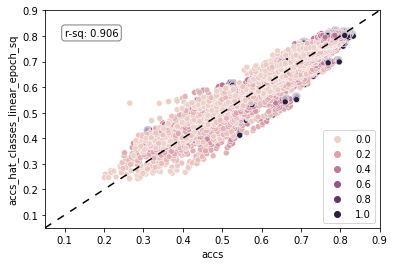

0.9058901486455159
mean val loss: 0.0019466117697485802


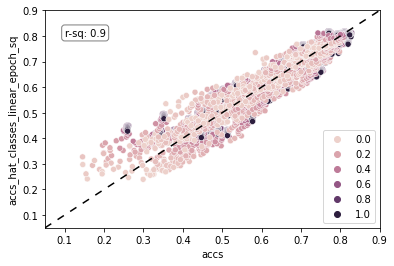

r_square val: 0.9001377213492536


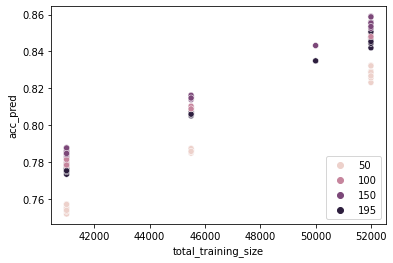

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.834884
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.843187
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.807510
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.816255
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.810355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.825667
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.845365
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.853507
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.848012


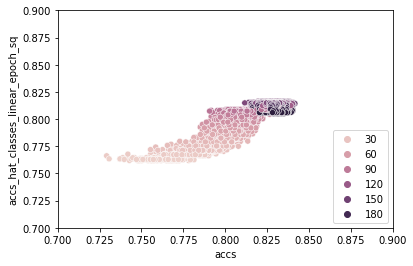

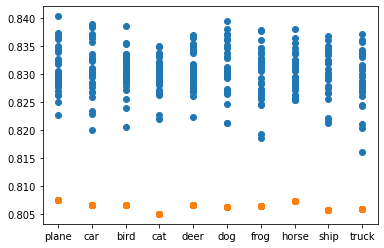

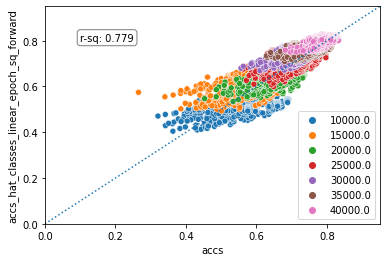

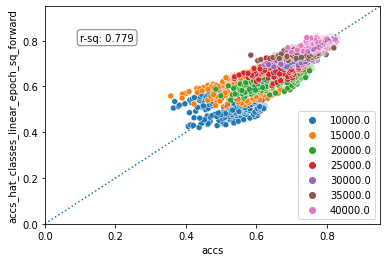

In [15]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch", "epoch**2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)
    results = plotting_printing.forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
    plotting_printing.plot_forward_testing(results, y_hat_name)
    results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
    plotting_printing.plot_forward_testing(results_val, y_hat_name)
    


# using all epochs, but just overall training dataset size:

In [16]:
#
y_hat_name = "accs_hat_total_n_epoch"

def func(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float) -> float:
    x_epoch = x[10]
    x_total_n = x[11]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch)**b) * c

np.random.seed(seed=4342133)
n_p = 5
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

param_name,a,b,c,total_n,epoch
param_value,0.291628,0.610618,0.505067,0.938806,0.157932


\begin{tabular}{lrrrrr}
\toprule
param\_name &    a &    b &    c &  total\_n &  epoch \\
\midrule
param\_value & 0.29 & 0.61 & 0.51 &     0.94 &   0.16 \\
\bottomrule
\end{tabular}

0.002126740663858756


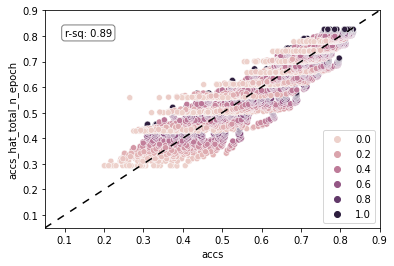

0.889530780631294
mean val loss: 0.0020191092579961707


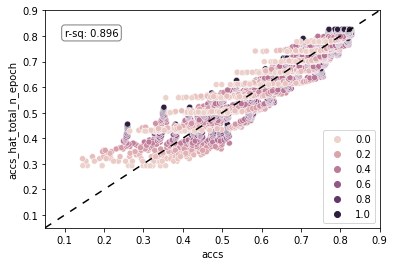

r_square val: 0.8964185594262806


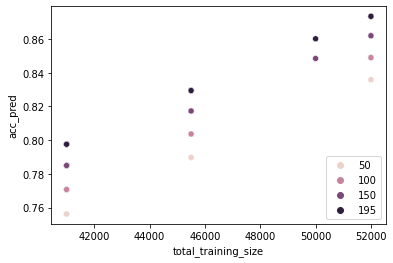

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.860179
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.848488
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.829447
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.817327
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.803647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.835845
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.873501
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.861985
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.849012


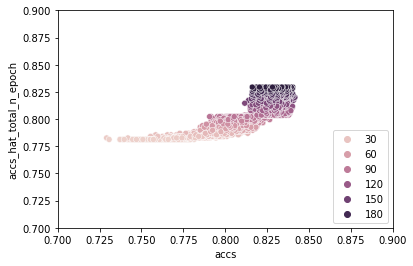

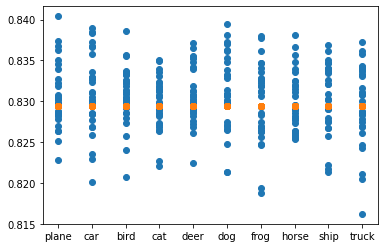

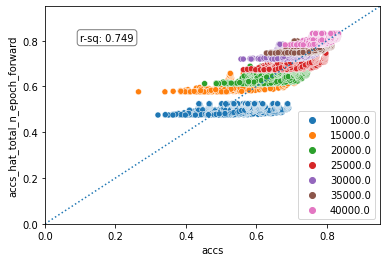

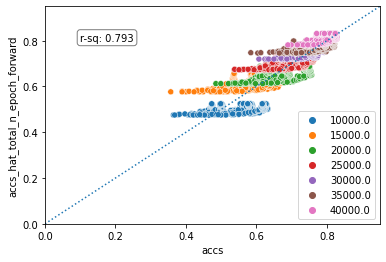

In [17]:
param_names = ["a", "b", "c"]
param_names = param_names + ["total_n", "epoch"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)
    results = plotting_printing.forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
    plotting_printing.plot_forward_testing(results, y_hat_name)
    results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
    plotting_printing.plot_forward_testing(results_val, y_hat_name)
    


### Using the arctan trick also for the total_n model:

In [18]:
y_hat_name = "accs_hat_total_n_arctan_epoch_arctan"

def func(x, a: float, b: float, c: float, d_total_n:float, d_total_n_2:float, d_epochs:float, d_epochs_2:float) -> float:
    x_epoch = x[10]
    x_total_n = x[11]
    return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c

np.random.seed(seed=92548)
n_p = 7
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

param_name,a,b,c,total_n_1,total_n_2,epoch_1,epoch_2
param_value,0.258653,0.796765,0.655657,0.762749,1.094052,0.118299,7.957926


\begin{tabular}{lrrrrrrr}
\toprule
param\_name &    a &    b &    c &  total\_n\_1 &  total\_n\_2 &  epoch\_1 &  epoch\_2 \\
\midrule
param\_value & 0.26 & 0.80 & 0.66 &       0.76 &       1.09 &     0.12 &     7.96 \\
\bottomrule
\end{tabular}

0.0018443510717479877


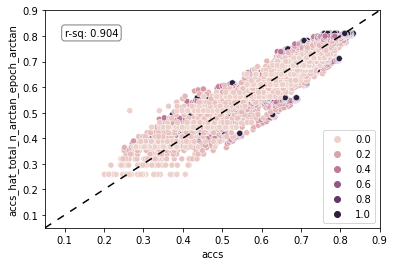

0.9041989337956403
mean val loss: 0.0017528024333603965


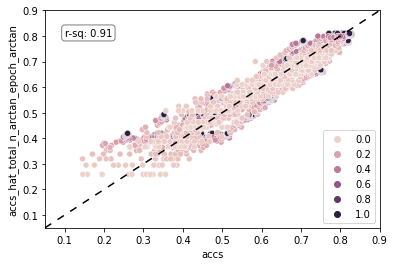

r_square val: 0.9100802493131182


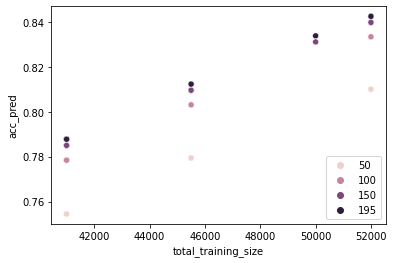

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.833972
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.831250
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.812433
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.809685
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.803171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.810141
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.842681
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.839970
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.833544


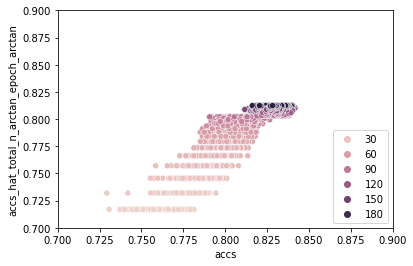

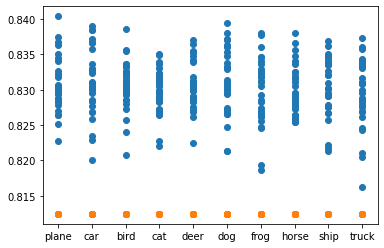

/tmp/ipykernel_553379/672612077.py:6: RuntimeWarning: invalid value encountered in power
  return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c


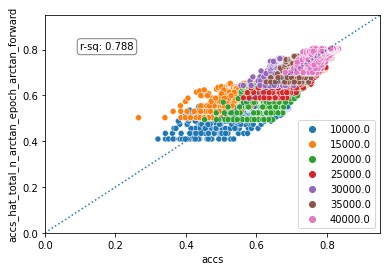

/tmp/ipykernel_553379/672612077.py:6: RuntimeWarning: invalid value encountered in power
  return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c


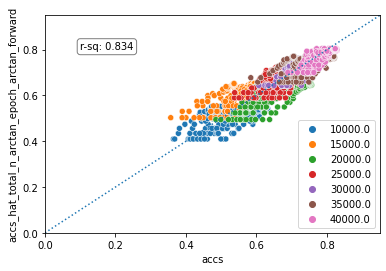

In [19]:
param_names = ["a", "b", "c"]
param_names = param_names + ["total_n_1", "total_n_2", "epoch_1", "epoch_2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)
    results = plotting_printing.forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
    plotting_printing.plot_forward_testing(results, y_hat_name)
    results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
    plotting_printing.plot_forward_testing(results_val, y_hat_name)
    
